In [1]:
# 1. IMPORT LIBRARIES & SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Library Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Buat folder untuk menyimpan output
for folder in ['models', 'data/processed', 'images']:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Folder '{folder}' berhasil dibuat.")

print("Libraries berhasil di-import dan struktur folder siap.")

Folder 'models' berhasil dibuat.
Folder 'data/processed' berhasil dibuat.
Folder 'images' berhasil dibuat.
Libraries berhasil di-import dan struktur folder siap.


In [3]:
# 2. DATA LOADING & CLEANING
df = pd.read_csv('/content/e-shop clothing 2008.csv', delimiter=';')

print(f"Data awal: {df.shape}")

# Hapus kolom tidak penting
cols_to_drop = ['year', 'session ID']
df_clean = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Hapus duplikat & missing values
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.dropna()

# TAMBAHAN PENTING: UBAH TEKS KE ANGKA (FIX ERROR 'C12')
from sklearn.preprocessing import LabelEncoder

# Cari kolom yang tipe datanya 'object' (teks/string)
object_cols = df_clean.select_dtypes(include=['object']).columns

# loop untuk mengubah teks menjadi angka
if len(object_cols) > 0:
    print(f"Terdeteksi kolom teks: {list(object_cols)}. Melakukan Encoding...")
    le = LabelEncoder()
    for col in object_cols:
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        print(f"   -> Kolom '{col}' berhasil diubah menjadi angka.")
else:
    print("Semua kolom sudah berupa angka.")

print(f"Data setelah cleaning: {df_clean.shape}")

df_clean.to_csv('data/processed/e_shop_clothing_final_cleaned.csv', index=False)
print("Data bersih tersimpan di 'data/processed/e_shop_clothing_final_cleaned.csv'")

Data awal: (165474, 14)
Terdeteksi kolom teks: ['page 2 (clothing model)']. Melakukan Encoding...
   -> Kolom 'page 2 (clothing model)' berhasil diubah menjadi angka.
Data setelah cleaning: (133540, 12)
Data bersih tersimpan di 'data/processed/e_shop_clothing_final_cleaned.csv'


/tmp/ipython-input-1766332355.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x=target_col, palette='viridis')


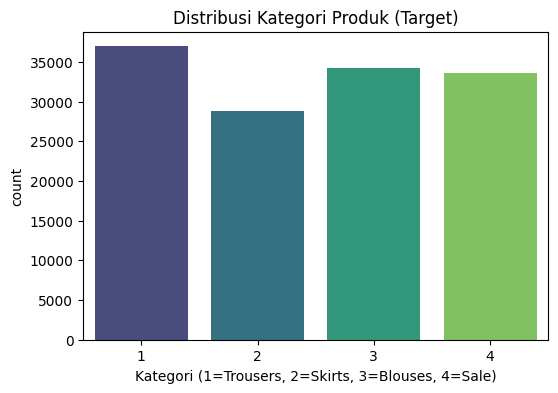

/tmp/ipython-input-1766332355.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x=target_col, y=price_col, palette='Set2')


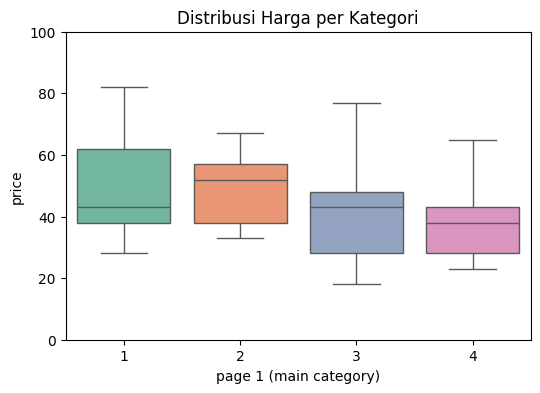

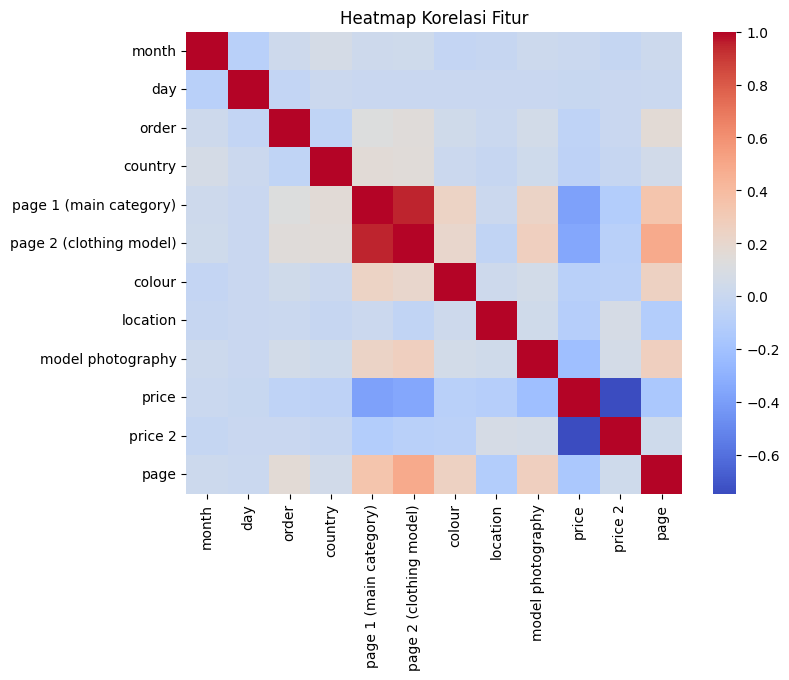

In [4]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)
target_col = 'page 1 (main category)'
price_col = 'price'

# Visualisasi 1: Distribusi Kelas
plt.figure(figsize=(6, 4))
sns.countplot(data=df_clean, x=target_col, palette='viridis')
plt.title('Distribusi Kategori Produk (Target)')
plt.xlabel('Kategori (1=Trousers, 2=Skirts, 3=Blouses, 4=Sale)')
plt.show()

# Visualisasi 2: Hubungan Harga vs Kategori
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_clean, x=target_col, y=price_col, palette='Set2')
plt.title('Distribusi Harga per Kategori')
plt.ylim(0, 100) # Zoom in harga 0-100 agar terlihat jelas
plt.show()

# Visualisasi 3: Korelasi Heatmap
plt.figure(figsize=(8, 6))
numeric_df = df_clean.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur')
plt.show()

In [5]:
# 4. PREPROCESSING (SPLIT & SCALE)
target_col = 'page 1 (main category)'

# 'page 2 (clothing model)' memberi tahu jawaban secara langsung.
leak_cols = ['page 2 (clothing model)']

# Pisahkan X (Fitur) dan y (Target)
X = df_clean.drop(columns=[target_col] + leak_cols, errors='ignore')
y = df_clean[target_col]

# Ubah target menjadi 0,1,2,3
y = y - 1

print(f"Fitur yang digunakan (X): {list(X.columns)}")

# 4. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan Scaler
joblib.dump(scaler, 'models/scaler.pkl')

# Gabungkan X dan y untuk disimpan
processed_train = pd.DataFrame(X_train_scaled, columns=X.columns)
processed_train['target'] = y_train.values
processed_train.to_csv('data/processed/train_data_processed.csv', index=False)

processed_test = pd.DataFrame(X_test_scaled, columns=X.columns)
processed_test['target'] = y_test.values
processed_test.to_csv('data/processed/test_data_processed.csv', index=False)

print("✅ Data Train/Test yang sudah di-scale tersimpan di 'data/processed/'")

Fitur yang digunakan (X): ['month', 'day', 'order', 'country', 'colour', 'location', 'model photography', 'price', 'price 2', 'page']
✅ Data Train/Test yang sudah di-scale tersimpan di 'data/processed/'


In [6]:
# 5. MODELING 1: LOGISTIC REGRESSION (Baseline)
print("\n 5. TRAINING MODEL 1: LOGISTIC REGRESSION")

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)

y_pred_lr = model_lr.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f" Akurasi Logistic Regression: {acc_lr:.4f}")

# Simpan Model
joblib.dump(model_lr, 'models/model_logistic_regression.pkl')


 5. TRAINING MODEL 1: LOGISTIC REGRESSION
 Akurasi Logistic Regression: 0.6621


['models/model_logistic_regression.pkl']

In [7]:
# 6. MODELING 2: RANDOM FOREST (Advanced ML)
print("\n 6. TRAINING MODEL 2: RANDOM FOREST")

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Random Forest tidak wajib pakai data scaled, tapi tidak masalah jika pakai
model_rf.fit(X_train_scaled, y_train)

y_pred_rf = model_rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f" Akurasi Random Forest: {acc_rf:.4f}")

# Simpan Model
joblib.dump(model_rf, 'models/model_random_forest.pkl')

# Feature Importance
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop 3 Fitur Paling Penting (Random Forest):")
for f in range(3):
    print(f"{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")



 6. TRAINING MODEL 2: RANDOM FOREST
 Akurasi Random Forest: 0.9875

Top 3 Fitur Paling Penting (Random Forest):
1. price (0.3371)
2. colour (0.2684)
3. location (0.1367)


In [8]:
# 7. MODELING 3: DEEP LEARNING (MLP)
print("\7. TRAINING MODEL 3: DEEP LEARNING (MLP)")

input_dim = X_train_scaled.shape[1]
num_classes = 4 # (0, 1, 2, 3)

# Arsitektur Model
model_dl = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),                 # Regularisasi
    Dense(32, activation='relu'),
    Dropout(0.2),                 # Regularisasi
    Dense(num_classes, activation='softmax') # Output Layer
])

# Compile
model_dl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history = model_dl.fit(
    X_train_scaled, y_train,
    validation_split=0.2, # 20% dari train dipakai validasi
    epochs=15,            # Bisa ditambah jika belum konvergen
    batch_size=64,
    verbose=1
)

# Evaluasi
loss_dl, acc_dl = model_dl.evaluate(X_test_scaled, y_test, verbose=0)
print(f" Akurasi Deep Learning: {acc_dl:.4f}")

# Prediksi kelas
y_pred_dl_proba = model_dl.predict(X_test_scaled)
y_pred_dl = np.argmax(y_pred_dl_proba, axis=1)

# Simpan Model
model_dl.save('models/model_deep_learning.h5')
print(" Semua model berhasil disimpan di folder 'models/'")

. TRAINING MODEL 3: DEEP LEARNING (MLP)
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5826 - loss: 0.9339 - val_accuracy: 0.8611 - val_loss: 0.4064
Epoch 2/15
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8184 - loss: 0.4583 - val_accuracy: 0.9395 - val_loss: 0.2239
Epoch 3/15
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8736 - loss: 0.3227 - val_accuracy: 0.9546 - val_loss: 0.1547
Epoch 4/15
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9005 - loss: 0.2547 - val_accuracy: 0.9642 - val_loss: 0.1168
Epoch 5/15
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9138 - loss: 0.2214 - val_accuracy: 0.9779 - val_loss: 0.0938
Epoch 6/15
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9252 - loss: 0.1936 - val_accuracy: 0.9815 - val_loss: 0.0787
Epoch 7/15
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9324 - loss: 0.1728 - val_accuracy: 0.9847 - val_loss: 0.0693
Epoch 8/15
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9391 - loss: 0.1583 - val_accurac

 Semua model berhasil disimpan di folder 'models/'


In [9]:
print(model_dl.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,750 (34.18 KB)

 Trainable params: 2,916 (11.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,834 (22.79 KB)

None



 8. FINAL EVALUATION


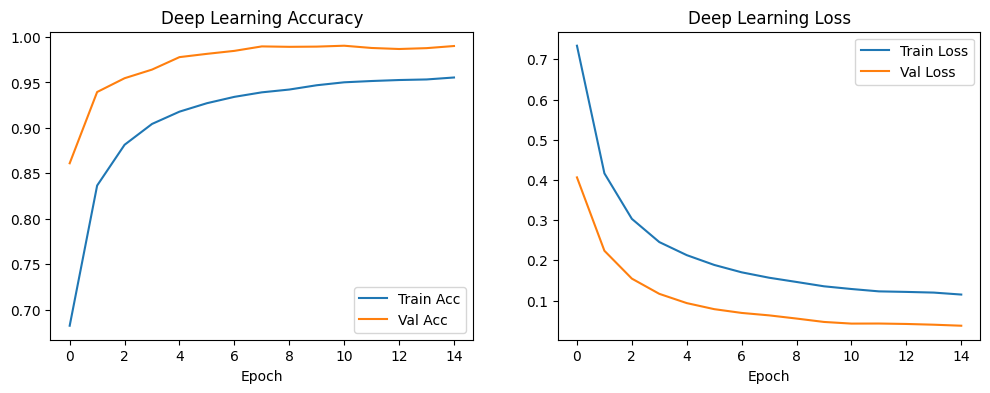

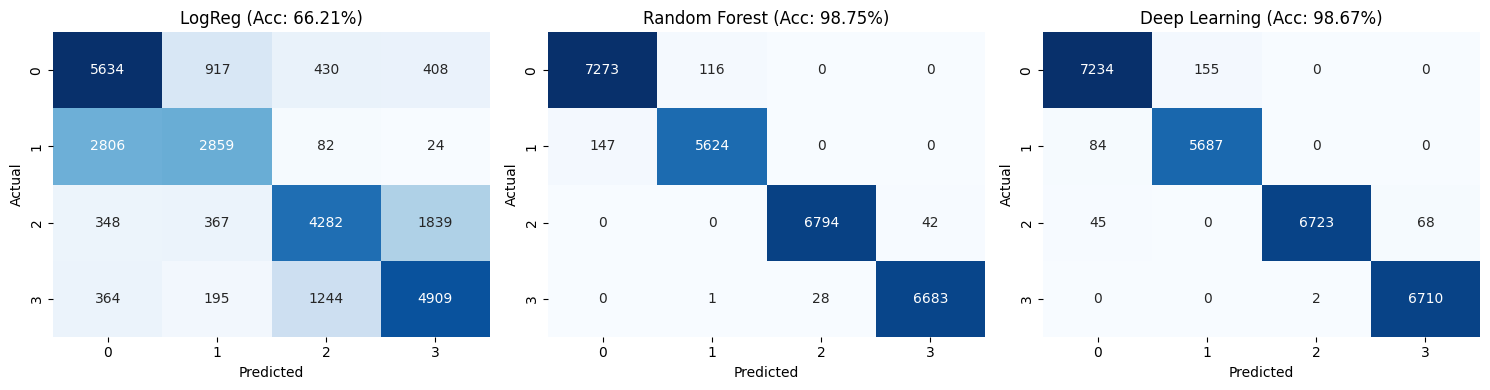

              precision    recall  f1-score   support

    Trousers       0.98      0.98      0.98      7389
      Skirts       0.97      0.99      0.98      5771
     Blouses       1.00      0.98      0.99      6836
        Sale       0.99      1.00      0.99      6712

    accuracy                           0.99     26708
   macro avg       0.99      0.99      0.99     26708
weighted avg       0.99      0.99      0.99     26708



In [10]:
# 8. EVALUATION & VISUALIZATION
print("\n 8. FINAL EVALUATION")

# 8.1 Plot Training History (Deep Learning)
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Deep Learning Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Deep Learning Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 8.2 Confusion Matrix Comparison
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_cm(y_test, y_pred_lr, f'LogReg (Acc: {acc_lr:.2%})')

plt.subplot(1, 3, 2)
plot_cm(y_test, y_pred_rf, f'Random Forest (Acc: {acc_rf:.2%})')

plt.subplot(1, 3, 3)
plot_cm(y_test, y_pred_dl, f'Deep Learning (Acc: {acc_dl:.2%})')

plt.tight_layout()
plt.show()

# 8.3 Final Classification Report (Best Model - MLP)
print(classification_report(y_test, y_pred_dl, target_names=['Trousers', 'Skirts', 'Blouses', 'Sale']))

/tmp/ipython-input-1250399131.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=df_results, palette='viridis')


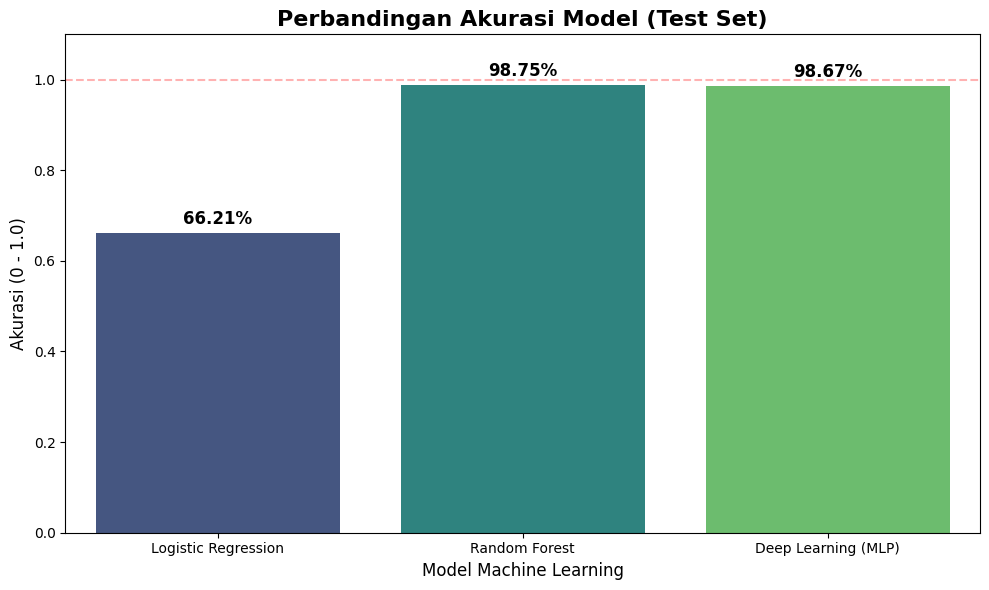

In [11]:
model_names = ['Logistic Regression', 'Random Forest', 'Deep Learning (MLP)']
accuracies = [acc_lr, acc_rf, acc_dl]

# Buat DataFrame agar mudah di-plot
df_results = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# 2. Membuat Plot
plt.figure(figsize=(10, 6))


ax = sns.barplot(x='Model', y='Accuracy', data=df_results, palette='viridis')

# 3. Mempercantik Grafik
plt.ylim(0, 1.1) # Batas Y dari 0 sampai 1.1 agar ada ruang untuk teks
plt.title('Perbandingan Akurasi Model (Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('Akurasi (0 - 1.0)', fontsize=12)
plt.xlabel('Model Machine Learning', fontsize=12)

# 4. Menambahkan Label Angka di Atas Batang
for p in ax.patches:
    # Mengambil tinggi batang
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.02,
            f'{height:.2%}',
            ha="center", fontsize=12, fontweight='bold', color='black')

# Tambahkan garis putus-putus pada y=1.0
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label='Perfect Accuracy')

plt.tight_layout()
plt.show()

HASIL EVALUASI PADA DATA TEST 

>> Mengevaluasi Model: Logistic Regression (Baseline)...
              precision    recall  f1-score   support

    Trousers       0.62      0.76      0.68      7389
      Skirts       0.66      0.50      0.57      5771
     Blouses       0.71      0.63      0.67      6836
        Sale       0.68      0.73      0.71      6712

    accuracy                           0.66     26708
   macro avg       0.67      0.65      0.65     26708
weighted avg       0.67      0.66      0.66     26708


>> Mengevaluasi Model: Random Forest (Advanced)...
              precision    recall  f1-score   support

    Trousers       0.98      0.98      0.98      7389
      Skirts       0.98      0.97      0.98      5771
     Blouses       1.00      0.99      0.99      6836
        Sale       0.99      1.00      0.99      6712

    accuracy                           0.99     26708
   macro avg       0.99      0.99      0.99     26708
weighted avg       0.99      0.99      0.99 

,Model,Accuracy,F1-Score
0,Logistic Regression (Baseline),0.6621,0.6586
1,Random Forest (Advanced),0.9875,0.9875
2,Deep Learning (MLP),0.9867,0.9868


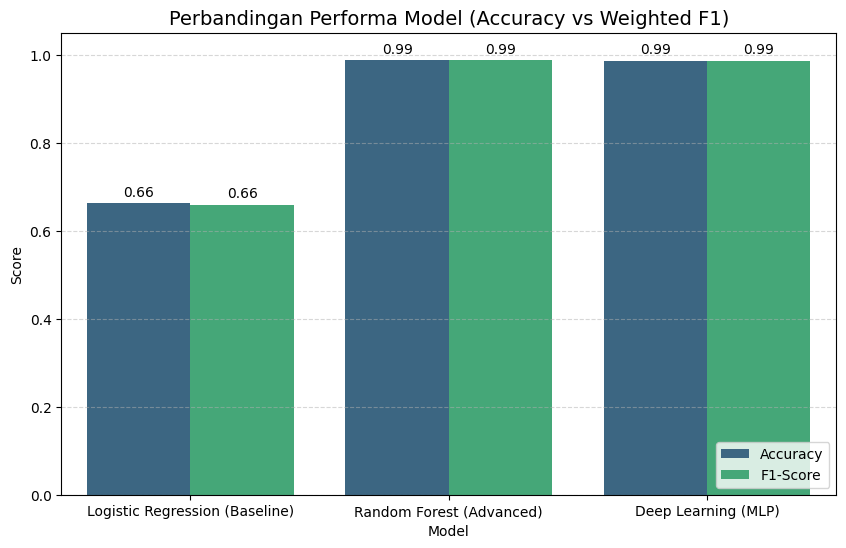

In [12]:
# EVALUATION & COMPARISON
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report
from IPython.display import display
import os

models_dict = {
    'Logistic Regression (Baseline)': model_lr,
    'Random Forest (Advanced)': model_rf,
    'Deep Learning (MLP)': model_dl
}

# Container hasil
final_metrics = []

print("HASIL EVALUASI PADA DATA TEST ")

# Loop untuk mengevaluasi setiap model
for name, model in models_dict.items():
    print(f"\n>> Mengevaluasi Model: {name}...")

    # 2. Lakukan Prediksi
    if name == 'Deep Learning (MLP)':
        y_pred_prob = model.predict(X_test_scaled, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
    else:
        # Prediksi SKLEARN (LogReg, RF)
        y_pred = model.predict(X_test_scaled)

    # 3. Hitung Metrik
    acc = accuracy_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    final_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1
    })

    # Target names (0:Trousers, 1:Skirts, 2:Blouses, 3:Sale)
    target_names = ['Trousers', 'Skirts', 'Blouses', 'Sale']
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# 4. Membuat Tabel DataFrame
df_metrics = pd.DataFrame(final_metrics)

print("\n=== TABEL PERBANDINGAN AKHIR ===")
# Format tampilan di Jupyter/Colab
display(df_metrics.style.format({
    'Accuracy': '{:.4f}',
    'F1-Score': '{:.4f}'
}))

# 5. Visualisasi Perbandingan Metrik
plt.figure(figsize=(10, 6))


df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot Bar Chart
ax = sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Perbandingan Performa Model (Accuracy vs Weighted F1)", fontsize=14)
plt.ylim(0, 1.05) # Batas y hingga 1.05
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

# Label Angka di atas batang
for container in ax.containers:

    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

if not os.path.exists('images'):
    os.makedirs('images')
plt.savefig('images/viz_model_comparison_metrics.png')
plt.show()